In [1]:
import wandb
import pandas as pd
from IPython.display import display
api = wandb.Api()
sweep = api.sweep("dpfrommer-projects/stanza/tublltwr")

data = []
for r in sweep.runs:
    if "test_reward" not in r.summary:
        continue
    d = {
        "num_traj": r.config["num_trajectories"],
        "sigma": r.config["smoothing_sigma"],
        "gains": r.config["diffuse_gains"] == True,
        "entrypoint": "diffusion" if "diffusion_bc" in r.config["entrypoint"] else "bc",
        "test_reward": r.summary["test_reward"],
        "rng_seed": r.config["rng_seed"]
    }
    if "test_deconv_reward" in r.summary:
        d["test_deconv_reward"] = r.summary["test_deconv_reward"]
    data.append(d)
data = pd.DataFrame(data)
display(data)


,num_traj,sigma,gains,entrypoint,test_reward,rng_seed,test_deconv_reward
0,30,0.500,False,diffusion,0.001150,46,0.001748
1,30,0.300,False,diffusion,0.001868,46,0.002363
2,30,0.100,False,diffusion,0.042244,46,0.023155
3,30,0.075,False,diffusion,0.128853,46,0.041818
4,30,0.050,False,diffusion,0.126169,46,0.087080
...,...,...,...,...,...,...,...
795,1,0.030,True,diffusion,0.461176,42,0.461322
796,1,0.020,True,diffusion,0.291389,42,0.292216
797,1,0.010,True,diffusion,0.221038,42,0.215541
798,1,0.005,True,diffusion,0.145317,42,0.145123


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
colors = list(sns.color_palette("Set2")) + list(sns.color_palette("Set1"))
#colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors]
#colors_dark = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for (r,g,b) in colors_dark]
markers = ["circle", "square", "triangle-up", "diamond", "cross"]
sns.set_theme(style="darkgrid")

def plot(data, x, ys, consolidate=["rng_seed"], style_func=lambda series, y: {}):
  # average over the ys
  groupby = list(set(data.columns) - set(ys) - set(consolidate))
  groups = data.groupby(groupby, group_keys=True)
  mean = groups.mean().reset_index()
  std = groups.std().reset_index()
  # group mean, std by things that are not
  # x or ys
  groupby = list(set(data.columns) - set([x] + ys + consolidate))
  mean = mean.groupby(groupby, group_keys=True)
  std = std.groupby(groupby, group_keys=True)

  # precompute all of the styles
  color_vals = set()
  for series, _ in mean:
    series = dict(zip(groupby, series))
    for y in ys:
      style = style_func(series, y)
      if style is None or "color_key" not in style:
        continue
      color_vals.add(style["color_key"])
  
  # hash the color vals to the colors
  color_map = {k: v for k, v in zip(color_vals, itertools.cycle(colors))}

  for (series, m), (_, s) in zip(mean,std):
    series = dict(zip(groupby, series))
    x_vals = m[x].to_numpy()
    for y in ys:
      if not y in m:
        continue
      y_vals = m[y].to_numpy()
      y_err_vals = s[y].to_numpy()
      if np.isnan(y_vals).any():
        not_nans = np.logical_not(np.isnan(y_vals))
        x_vals = x_vals[not_nans]
        y_vals = y_vals[not_nans]
        y_err_vals = y_err_vals[not_nans]

      style = style_func(series, y)
      if style is None:
        continue
      color_key = style["color_key"]
      del style["color_key"]
      color = color_map[color_key]
      if "color_mod" in style:
        color_mod = style["color_mod"]
        del style["color_mod"]
        color = color_mod(color)
      if "markers" in style:
        marker_first = style["markers"] == "first"
        del style["markers"]
        if marker_first:
          marker_style = {k: v for k, v in style.items() if k.startswith("marker")}
          for k in marker_style:
            del style[k]
      else:
        marker_first = False

      plt.plot(x_vals, y_vals, color=color, **style)
      plt.fill_between(x_vals, y_vals - y_err_vals, y_vals + y_err_vals, color=color, alpha=0.2)
      if marker_first:
        plt.plot(x_vals[0], y_vals[0], color=color, 
                 linestyle=None, **marker_style, clip_on=False)

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

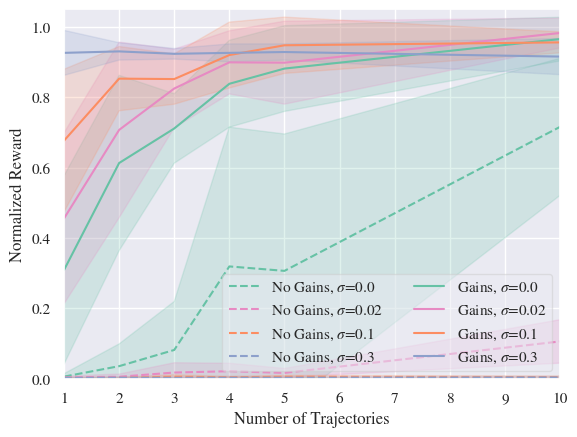

In [4]:
def style(series, y):
    gains = "Gains, " if series["gains"] else "No Gains, "
    replica = ", deconv" if y == "test_deconv_reward" else ""
    sigma = series["sigma"]
    # if not series["gains"]:
    #     return None
    if y == "test_deconv_reward":
        return None
    return {
        "label": f"{gains}$\sigma$={sigma}{replica}",
        "color_key": sigma,
        "linestyle": "-" if series["gains"] and y == "test_reward" else "--",
    }
# filtered_data = data[data["lambda"] < 0.1]
filtered_data = data
# filtered_data = filtered_data.drop("test_deconv_reward", axis="columns")
filtered_data = filtered_data[filtered_data["sigma"].isin([0., 0.02, 0.1, 0.3])]
plot(filtered_data, "num_traj", ["test_reward", "test_deconv_reward"], style_func=style)
plt.xlim([1, 10])
plt.ylim([0, 1.05])
plt.legend(loc="lower right", ncols=2, framealpha=0.5)
# plt.xticks([5, 15, 30, 45, 60])
plt.xlabel("Number of Trajectories")
plt.ylabel("Normalized Reward")
plt.savefig("quadrotor_traj.pdf", bbox_inches="tight")

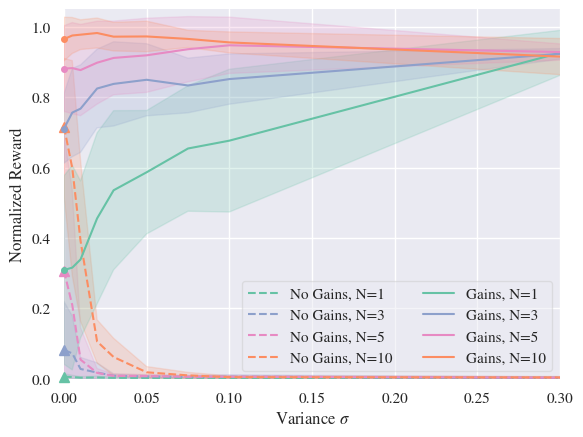

In [5]:
def style(series, y):
    gains = "Gains, " if series["gains"] else "No Gains, "
    replica = ", deconv" if y == "test_deconv_reward" else ""
    N = series["num_traj"]
    if y == "test_deconv_reward":
        return None
    return {
        "label": f"{gains}N={N}{replica}",
        "markers": "first",
        "marker": "o" if series["gains"] else "^",
        "markersize": 4 if series["gains"] else 7,
        "color_key": series["num_traj"],
        "linestyle": "-" if series["gains"] and y == "test_reward" else "--",
    }

plt.xlabel("Variance $\sigma$")
plt.xlim([0, 0.3])
plt.ylim([0, 1.05])
plt.ylabel("Normalized Reward")
filtered_data = data
filtered_data = filtered_data[filtered_data["num_traj"].isin([1, 3, 5, 10])]
plot(filtered_data, "sigma", ["test_reward", "test_deconv_reward"], style_func=style)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend(loc="lower right", ncols=2, framealpha=0.5)
plt.savefig("quadrotor_sigma.pdf", bbox_inches='tight')